# Análise de preços das ações das empresas AMD, ASUS, Intel, MSI, NVIDIA

---


Vamos analisar os DataFrames das seguintes empresas: AMD, ASUS, INTEL, MSI, NVIDIA. Ver o comportamento delas ao longo dos anos. 

As colunas do DataFrames estão organizadas da seguinte forma:

* Date: Data (AAAA-MM-DD)

* Open: O valor que a ação abriu o dia

* High: O maior valor que ela atingiu no dia

* Low: O menor valor que ela atingiiu no dia

* Close: O valor que a ação fechou o dia

* Adj Close: "Adjusted Close" preço de fechamento ajustado.

* Volume: Volume de ações negociadas.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline 

amd = pd.read_csv("AMD (1980-2023).csv", parse_dates=['Date'])
asus = pd.read_csv("ASUS (2000-2023).csv", parse_dates=['Date'])
intel = pd.read_csv("Intel (1980-2023).csv", parse_dates=['Date'])
msi = pd.read_csv("MSI (1962-2023).csv", parse_dates=['Date'])
nvidia = pd.read_csv("NVIDIA (1999-2023).csv", parse_dates=['Date'])

In [ ]:
def filter_df(df, start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    df_filtered = df[(df.Date >= start_date) & (df.Date <= end_date)]
    return df_filtered

In [ ]:
nvidia.info()

In [ ]:
# Definindo o intervalo de tempo nos dataframes 2000 - 2023
start_date = '2000-01-01'
end_date = '2023-04-17'

df_list = [amd, asus, intel, msi, nvidia]

df_list_filtered = []

for df in df_list:
    df_filtered = filter_df(df, start_date, end_date)
    df_list_filtered.append(df_filtered)

amd_2000, asus_2000, intel_2000, msi_2000, nvidia_2000 = df_list_filtered


In [ ]:
# price plot
labels = ['AMD', 'ASUS', 'INTEL', 'MSI', 'NVIDIA']
fig, ax = plt.subplots(figsize=(20,8))
for i,df in enumerate(df_list_filtered):
    sns.lineplot(data=df, x="Date", y="Adj Close", label=labels[i])

ax.legend(title="Companies")
ax.set(xlabel='Date', ylabel='Price Close', title='Movimet Stock Price (2000-2023)')

>Aqui podemos observar que a ASUS sempre esteve em alta ao longo dos anos e em 2020 ela caiu como a maioria das empresas, provavelmente por conta da pandemia do COVID-19.

>Podemos notar também que a empresa MSI teve grande evolução a partir de 2016 e se encontra hoje entre as com maior valor de ação.

>A empresa NVIDIA se desenvolveu muito no período de pandemia e assumindo o lugar entre as 3 com maior valor de ação.

In [49]:
nvidia_2020 = filter_df(nvidia, '2022-01-01', '2023-04-17')


In [ ]:
# volume plot x price NVIDIA
fig, ax1 = plt.subplots(figsize=(20,8))

sns.barplot(data=nvidia_2020, x="Month", y="Volume", ax=ax1)
ax1.set_ylabel('Volume')


ax2 = ax1.twinx()
sns.lineplot(data=nvidia_2020, x="Month", y="Adj Close", color='b', ax=ax2, alpha=0.5)
ax2.set_ylabel('Adj Close')


ax2.set(xlabel='Date', title='Volume NVIDIA (2021-2023)')
plt.xticks(rotation = 45)

In [70]:
# Definindo uma função para plotar os gráficos de preço de fechamento da ação com volume em um dado intervalo de tempo
def draw_plot(data,start_date, end_date, dataset_name):
    df = filter_df(data, start_date, end_date)
    fig, ax= plt.subplots(figsize=(20,8))
    sns.lineplot(data=df, x='Date', y='Adj Close', color='r', ax=ax)

    ax1= ax.twinx()
    ax1.bar(data=df, x='Date', height='Volume', alpha=0.8)

    

    ax1.set(xlabel='Date', ylabel='Volume', title=f'{dataset_name} Volume and Close Price from {start_date}')


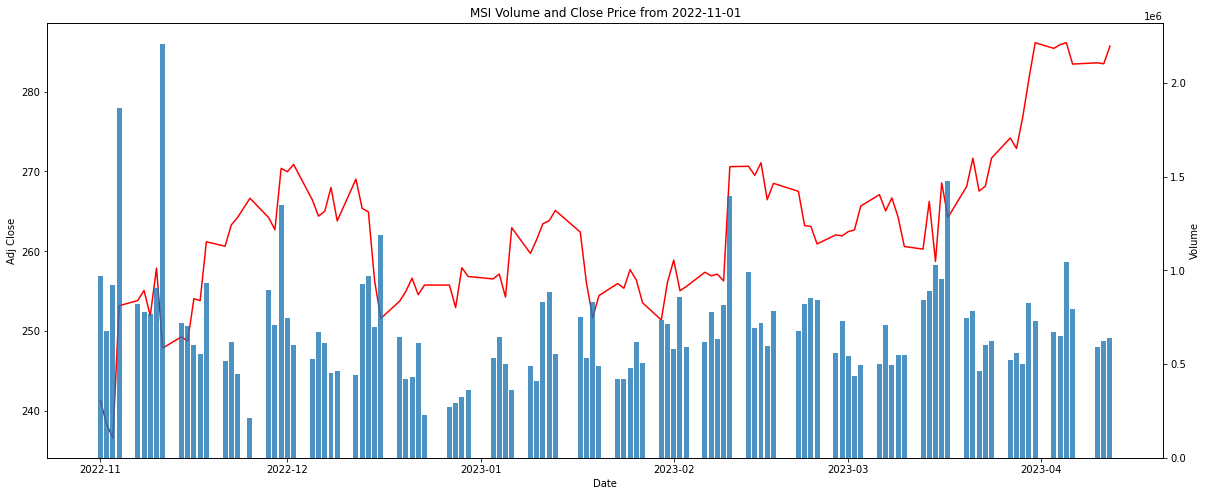

In [71]:
draw_plot(msi, '2022-11-01', '2023-04-17', 'MSI')

In [ ]:
draw_plot()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=nvidia_2020, x="Date", y="High", color='g')
sns.lineplot(data=nvidia_2020, x="Date", y="Low", color='r')
#sns.lineplot(data=nvidia_2020, x="Date", y="Adj Close", color='b')